In [3]:
# Import 

import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
%matplotlib inline

import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
import tensorflow as tf
from keras.callbacks import *
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
# scalable hyperparameter optimization framework using hyperparameter search
import keras_tuner as kt

2024-04-17 10:56:01.398575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 10:56:01.398708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 10:56:01.553502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
os.chdir(r"/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset")

In [6]:
COVID_metadata = pd.read_excel('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
Lung_Opacity_metadata = pd.read_excel('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx')
Normal_metadata = pd.read_excel('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
Pneumonia_metadata = pd.read_excel('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')

# 0. Meta Data files

In [7]:
df_metadata = pd.concat([COVID_metadata, Lung_Opacity_metadata, Normal_metadata, Pneumonia_metadata], ignore_index = True)
df_metadata.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [8]:
df_metadata['LABEL'] = df_metadata['FILE NAME'].str.split('-').str[0]
print("Les classes uniques sont :", df_metadata['LABEL'].unique())
print("Les résolutions uniques sont :", df_metadata['SIZE'].unique())
print("Les formats de fichier uniques sont :", df_metadata['FORMAT'].unique())
print("Nombre de radiographies :", len(df_metadata))

Les classes uniques sont : ['COVID' 'Lung_Opacity' 'NORMAL' 'Viral Pneumonia']
Les résolutions uniques sont : ['256*256']
Les formats de fichier uniques sont : ['PNG']
Nombre de radiographies : 21165


# I. Image Data

In [9]:
# Chemin vers le dossier contenant les catégories
root_folder = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Initialiser une liste pour stocker les métadonnées
data = []

# Parcourir chaque catégorie de dossier
for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
    images_folder = os.path.join(root_folder, category, 'images')
    if os.path.isdir(images_folder):
        for image_name in os.listdir(images_folder):
            image_path = os.path.join(images_folder, image_name)
            if os.path.isfile(image_path):
                # Ouvrir l'image pour obtenir des informations supplémentaires
                with Image.open(image_path) as img:
                    width, height = img.size
                    resolution = f"{width}x{height}"
                    channels = img.mode
                    # Convertir le mode de l'image en nombre de canaux
                    channels_count = len(channels)
                    # Ajouter les métadonnées à la liste
                    data.append({
                        'FILE NAME': image_name,
                        'FORMAT' : "",
                        'SIZE': resolution,
                        'LABEL': category,
                        'CHANNELS': channels_count,
                        'PATH': image_path})

# Créer un DataFrame à partir des métadonnées collectées
df = pd.DataFrame(data)
df['FORMAT'] = df['FILE NAME'].str.split('.').str[1]
df['FILE NAME'] = df['FILE NAME'].str.split('.').str[0]
df['FORMAT'] = df['FORMAT'].str.upper()

def source_extract(url):
    pattern = re.compile(r'https?://(?:www\.)?([^/]+)')
    match = pattern.search(url)
    if match:
        return match.group(1)
    else:
        return None

# Afficher les premières lignes du DataFrame pour vérifier
print(df.head())

    FILE NAME FORMAT     SIZE  LABEL  CHANNELS  \
0  COVID-1994    PNG  299x299  COVID         1   
1  COVID-1825    PNG  299x299  COVID         1   
2   COVID-517    PNG  299x299  COVID         1   
3   COVID-532    PNG  299x299  COVID         1   
4  COVID-2272    PNG  299x299  COVID         1   

                                                PATH  
0  /kaggle/input/covid19-radiography-database/COV...  
1  /kaggle/input/covid19-radiography-database/COV...  
2  /kaggle/input/covid19-radiography-database/COV...  
3  /kaggle/input/covid19-radiography-database/COV...  
4  /kaggle/input/covid19-radiography-database/COV...  


In [11]:
# Uniformisation de la Nomemclature de la colonne 'FILE NAME' en vue de la fusion des dataframe dans la cellule suivante
df_metadata['FILE NAME'] = df_metadata['FILE NAME'].str.replace('NORMAL', 'Normal')

In [12]:
# Création d'un tableau propre pour faciliter les analyses
df_metadata_clean = pd.merge(df, df_metadata[['FILE NAME', 'URL']], on = 'FILE NAME', how = 'left')

def source_extract(url):
    pattern = re.compile(r'https?://(?:www\.)?([^/]+)')
    match = pattern.search(url)
    if match:
        return match.group(1)
    else:
        return None

df_metadata_clean['SOURCE'] = df_metadata_clean['URL'].astype(str).apply(source_extract)

In [13]:
# Fonction pour calculer l'intensité lumineuse moyenne d'une image
def calc_mean_intensity(image_path):
    img = mpimg.imread(image_path)
    # Convertir en nuances de gris si l'image est en couleur
    if img.ndim == 3:
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        img_gray = img
    return np.mean(img_gray)

# Appliquer la fonction à chaque chemin d'image pour obtenir l'intensité moyenne
df_metadata_clean['MEAN_INTENSITY'] = df_metadata_clean['PATH'].apply(calc_mean_intensity)

In [14]:
print("Les vraies classes uniques sont :", df_metadata_clean['LABEL'].unique())
print("Les vraies résolutions uniques sont :", df_metadata_clean['SIZE'].unique())
print("Les vrais formats de fichier uniques sont :", df_metadata_clean['FORMAT'].unique())
print("Les vrais nombres de canaux sont :", df_metadata_clean['CHANNELS'].unique())
print("Les sources uniques sont :", df_metadata_clean['SOURCE'].unique())
print("Nombre de radiographies :", len(df_metadata_clean))

Les vraies classes uniques sont : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
Les vraies résolutions uniques sont : ['299x299']
Les vrais formats de fichier uniques sont : ['PNG']
Les vrais nombres de canaux sont : [1 3]
Les sources uniques sont : ['bimcv.cipf.es' 'eurorad.org' 'github.com' 'sirm.org' 'kaggle.com']
Nombre de radiographies : 21165


In [15]:
df_images=df_metadata_clean

In [18]:
# Les masques
# Chemin vers le dossier contenant les catégories
root_folder = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Initialiser une liste pour stocker les métadonnées
data = []

# Parcourir chaque catégorie de dossier
for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
    images_folder = os.path.join(root_folder, category, 'masks')
    if os.path.isdir(images_folder):
        for image_name in os.listdir(images_folder):
            image_path = os.path.join(images_folder, image_name)
            if os.path.isfile(image_path):
                # Ouvrir l'image pour obtenir des informations supplémentaires
                with Image.open(image_path) as img:
                    width, height = img.size
                    resolution = f"{width}x{height}"
                    channels = img.mode
                    # Convertir le mode de l'image en nombre de canaux
                    # Généralement, 'RGB' -> 3, 'L' -> 1 (niveaux de gris), etc.
                    channels_count = len(channels)
                    # Ajouter les métadonnées à la liste
                    data.append({
                        'FILE NAME': image_name,
                        'FORMAT' : "",
                        'SIZE': resolution,
                        'LABEL': category,
                        'CHANNELS': channels_count,
                        'PATH': image_path})

# Créer un DataFrame à partir des métadonnées collectées
df = pd.DataFrame(data)

# Afficher les premières lignes du DataFrame pour vérifier
df['FORMAT'] = df['FILE NAME'].str.split('.').str[1]
df['FILE NAME'] = df['FILE NAME'].str.split('.').str[0]
df['FORMAT'] = df['FORMAT'].str.upper()
df_masks = df
df_masks.head()

,FILE NAME,FORMAT,SIZE,LABEL,CHANNELS,PATH
0,COVID-1994,PNG,256x256,COVID,3,/kaggle/input/covid19-radiography-database/COV...
1,COVID-1825,PNG,256x256,COVID,3,/kaggle/input/covid19-radiography-database/COV...
2,COVID-517,PNG,256x256,COVID,3,/kaggle/input/covid19-radiography-database/COV...
3,COVID-532,PNG,256x256,COVID,3,/kaggle/input/covid19-radiography-database/COV...
4,COVID-2272,PNG,256x256,COVID,3,/kaggle/input/covid19-radiography-database/COV...


# II. Models Training

In [19]:
# Définition d'une fonction pour le préprocessing des images
def preproc_img(df_images,
                df_masks,
                n_img=max(df_images['LABEL'].value_counts()),
                resolution=[28, 28, 1],
                normalize=False,
                with_masks=False):

    # Implantation de la reproductabilité
    np.random.seed(42)

    # Gestion des erreurs
    if (resolution[2] != 1 and resolution[2] != 3):
        return print("Le nombre de canaux doit être de 1 (en nuances de gris) ou de 3 (en couleur)")

    if (resolution[0] != resolution[1]):
        return print("La largeur de l'image doit être la même que sa hauteur.")

    df_images_selected_list = []
    for label, group in df_images.groupby('LABEL'):
        n_samples = min(len(group), n_img)  # Prend le minimum entre le nombre d'images disponibles et n_img
        df_images_selected_list.append(group.sample(n = n_samples, replace = False))
    df_images_selected = pd.concat(df_images_selected_list)

    # Initialiser une liste pour stocker les images prétraitées
    images = []

    # Sélectionner le nombre d'image à utiliser par classe
    df_masks_selected = df_masks[df_masks['FILE NAME'].isin(df_images_selected['FILE NAME'])] if with_masks else None

    for i in range(len(df_images_selected)):
        # Récupérer les chemins des images et des masques
        img_path = df_images_selected['PATH'].iloc[i]
        mask_path = df_masks_selected['PATH'].iloc[i] if with_masks else None

        # Chargement de l'image et du masque en nuances de gris et en 8 bits
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

        if resolution[2] == 3:
            # Chargement de l'image en couleur
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        img_resized = cv2.resize(img, (resolution[0], resolution[1]))

        # Normalisation des valeurs des pixels
        if normalize:
            img_normalized = img_resized / 255.0
        else:
            img_normalized = img_resized

        if with_masks:
            # Application des masques par défaut
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
            mask_resized = cv2.resize(mask, (resolution[0], resolution[1]))
            img_masked = cv2.bitwise_and(img_normalized, img_normalized, mask = mask_resized)
            # Ajout de l'image à la liste
            images.append(img_masked)
        else:
            images.append(img_normalized)

    # Reshaper pour ajouter la dimension du canal
    data = np.array(images).reshape(-1, resolution[0], resolution[1], resolution[2])
    target = df_images_selected['LABEL']

    # Renvoie l'ensemble des données et la variable cible
    return data, target

## 2.1 EfficentNets models

### 2.1.1 EfficientNetB4 unfreeze transfert learning

In [20]:
# Data preprocessing
# Specify the models Input data resolution 
model_resolution = [380, 380, 3]

data, target = preproc_img(df_images=df_images, df_masks=df_masks, n_img=1345, resolution=model_resolution, with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

print("Max value X_train:", X_train.max())
print("Max value X_test :", X_train.max())

label_encoder = LabelEncoder()
# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier la transformation
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot        :", y_test.shape)

X_train shape: (4304, 380, 380, 3)
X_test  shape: (1076, 380, 380, 3)
Max value X_train: 255
Max value X_test : 255
Labels de l'ensemble d'entrainement après encodage one-hot : (4304, 4)
Labels de l'ensemble de test après encodage one-hot        : (1076, 4)


In [21]:
# Import EffcientNet model
from keras.applications import EfficientNetB4

In [22]:
base_model = EfficientNetB4(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=model_resolution,
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Unfreeze the base model
base_model.trainable = True

inputs = keras.Input(shape=model_resolution)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)

retrained_B4 = keras.Model(inputs, outputs)

retrained_B4.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
hist = retrained_B4.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


2024-04-17 11:09:41.492616: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,144,191,191]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,144,193,193]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-17 11:09:42.227299: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.73478422s
Trying algorithm eng3{k11=2} for conv (f32[32,144,191,191]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,144,193,193]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-17 11:

107/108 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7330 - loss: 0.7272

2024-04-17 11:14:12.085195: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[19,144,191,191]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,144,193,193]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-17 11:14:12.169225: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.084129689s
Trying algorithm eng3{k11=2} for conv (f32[19,144,191,191]{3,2,1,0}, u8[0]{0}) custom-call(f32[19,144,193,193]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-17 11

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7340 - loss: 0.7248

W0000 00:00:1713352573.083344      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713352605.651885      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/108 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.7350 - loss: 0.7224 - val_accuracy: 0.5366 - val_loss: 1.0466
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9516 - loss: 0.1526 - val_accuracy: 0.5784 - val_loss: 1.0118
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9806 - loss: 0.0645 - val_accuracy: 0.7642 - val_loss: 0.5476
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9907 - loss: 0.0332 - val_accuracy: 0.8769 - val_loss: 0.3136
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9958 - loss: 0.0213 - val_accuracy: 0.8641 - val_loss: 0.3338
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9932 - loss: 0.0262 - val_accuracy: 0.9199 - val_loss: 0.2391
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9971 - loss: 0.0111 - val_accuracy: 0.9326 - val_loss: 0.2400
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9930 - loss: 0.0224 - val_accuracy: 0.928

In [24]:
hist_dict = {'Accuracy' : hist.history['accuracy'],
             'Loss' : hist.history['loss'],
             'Val_accuracy' : hist.history['val_accuracy'],
             'Val_loss' : hist.history['val_loss']}

df_EfficientNetB4_hist = pd.DataFrame(hist_dict)
df_EfficientNetB4_hist['epochs'] = np.arange(1, 21)
df_EfficientNetB4_hist.head()


,Accuracy,Loss,Val_accuracy,Val_loss,epochs
0,0.840256,0.461547,0.536585,1.046554,1
1,0.951205,0.142684,0.578397,1.011841,2
2,0.981121,0.062923,0.764228,0.547555,3
3,0.990125,0.037652,0.876887,0.313648,4
4,0.993029,0.025435,0.864111,0.333764,5


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

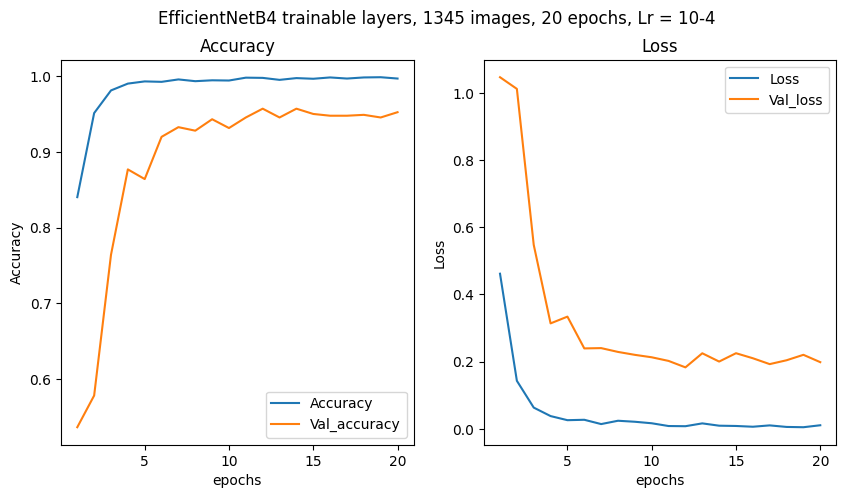

In [32]:
#sns.lineplot(x=np.array(df.index[0:20]), y=df.accuracy[0:20].values, markers=True, data=df[0:20]);

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('EfficientNetB4 trainable layers, 1345 images, 20 epochs, Lr = 10-4')

sns.lineplot(ax=axes[0], data=df_EfficientNetB4_hist, x='epochs', y='Accuracy', label='Accuracy', markers=True);
sns.lineplot(ax=axes[0], data=df_EfficientNetB4_hist, x='epochs', y='Val_accuracy', label='Val_accuracy', markers=True);
axes[0].set_title('Accuracy')
axes[0].legend()


axes[1].set_title('Loss')
sns.lineplot(ax=axes[1], data=df_EfficientNetB4_hist, x='epochs', y='Loss', label='Loss', markers=True);
sns.lineplot(ax=axes[1], data=df_EfficientNetB4_hist, x='epochs', y='Val_loss', label='Val_loss', markers=True);
axes[1].legend()

plt.show();

In [27]:
# Confusion matrix and Classification report
EfficientNetB4_preds = retrained_B4.predict(X_test)

 1/34 ━━━━━━━━━━━━━━━━━━━━ 5:18 10s/step

W0000 00:00:1713355831.672642      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 985ms/step


W0000 00:00:1713355864.174883      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


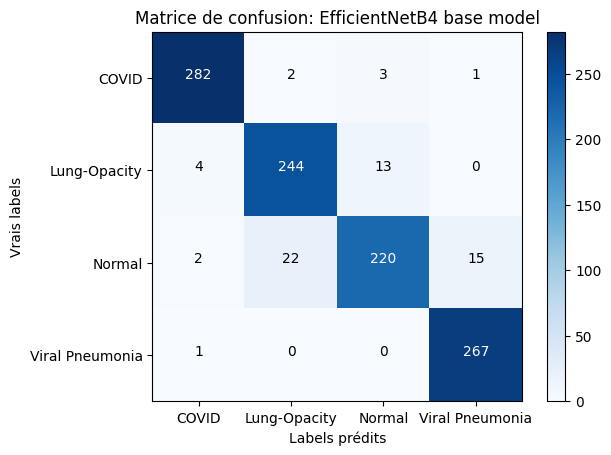

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
import itertools # Pour créer des itérateurs

test_pred_EfficientNetB4_class = EfficientNetB4_preds.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

# Matrice de confusion en couleurs  
cnf_matrix = confusion_matrix(y_test_class, test_pred_EfficientNetB4_class)

class_name = ['COVID', 'Lung-Opacity', 'Normal', 'Viral Pneumonia']

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion: EfficientNetB4 base model")
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name)
plt.yticks(tick_marks, class_name)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

In [29]:
# Classiifcation report
print(classification_report(y_test_class, test_pred_EfficientNetB4_class, target_names=class_name))

                 precision    recall  f1-score   support

          COVID       0.98      0.98      0.98       288
   Lung-Opacity       0.91      0.93      0.92       261
         Normal       0.93      0.85      0.89       259
Viral Pneumonia       0.94      1.00      0.97       268

       accuracy                           0.94      1076
      macro avg       0.94      0.94      0.94      1076
   weighted avg       0.94      0.94      0.94      1076

